## Exploratory Data Analysis (EDA)
**Project:** Causal Uplift Service
**Dataset:** Hillstrom Email Analytics

In this notebook, we analyze the results of the randomized marketing experiment.
Our goals are:
1. **Validate Randomization:** Ensure the Treatment and Control groups are balanced (fair A/B test).
2. **Calculate Naive Uplift:** Determine the overall impact of the email campaign (Average Treatment Effect).
3. **Explore Heterogeneity:** See if certain user segments (e.g., High Spenders vs. Low Spenders) react differently to the email.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Configure visual settings for professional plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

### 1. Load Processed Data
We load the clean dataset from our `artifacts/` folder. This data contains only the "Men's Email" (Treatment) and "No Email" (Control) groups.

In [2]:
# Load the dataset generated by data_ingestion.py
df = pd.read_csv('../artifacts/customer_data.csv')

# Display basic info
print(f"Total Rows: {df.shape[0]}")
print(f"Total Columns: {df.shape[1]}")
df.head()

Total Rows: 42613
Total Columns: 13


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,visit,conversion,spend,treatment,urban
0,6,3) $200 - $350,329.08,1,1,Rural,1,Web,0,0,0.0,0,0
1,9,5) $500 - $750,675.83,1,0,Rural,1,Web,0,0,0.0,1,0
2,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,0,0,0.0,1,0
3,2,2) $100 - $200,101.64,0,1,Urban,0,Web,1,0,0.0,1,1
4,4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,0,0,0.0,0,0


### 2. Randomization Check
Before calculating Lift, we must verify the experiment was fair.
If the **Treatment Group** (people who got the email) has significantly higher income or spending history than the **Control Group**, our results will be biased.

We expect the means of features like `history`, `recency`, and `newbie` to be roughly equal across both groups.

In [3]:
# Group by 'treatment' and compare average features
randomization_check = df.groupby('treatment')[['history', 'recency', 'mens', 'womens', 'newbie']].mean()

# Rename index for clarity
randomization_check.index = ['Control (No Email)', 'Treatment (Email)']
randomization_check

,history,recency,mens,womens,newbie
Control (No Email),240.882653,5.749695,0.553224,0.547639,0.501971
Treatment (Email),242.835931,5.773642,0.550946,0.551415,0.501525


### Visual Balance Check
A simple table of averages can hide skewed distributions. Let's look at the distribution of **Spending History**.
If the boxplots look identical, the randomization was successful.

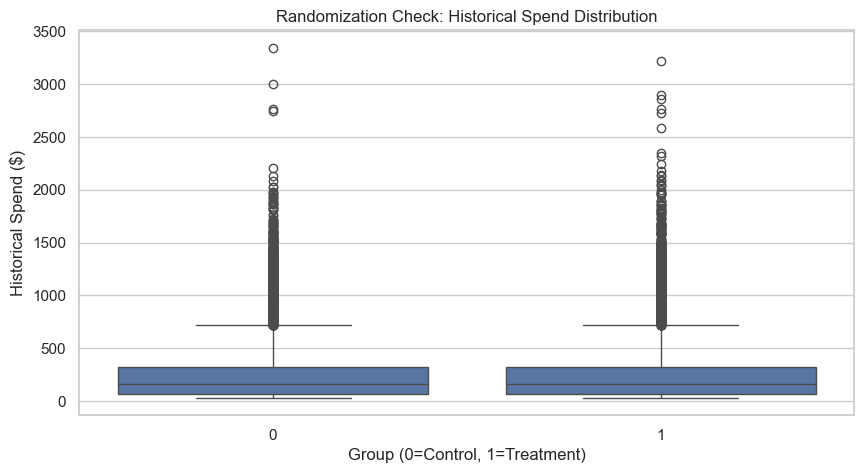

In [4]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='treatment', y='history', data=df)
plt.title('Randomization Check: Historical Spend Distribution')
plt.xlabel('Group (0=Control, 1=Treatment)')
plt.ylabel('Historical Spend ($)')
plt.show()

### 3. Overall Campaign Performance (ATE)
Now we answer the business question: **Did the email work?**

We calculate the **Average Treatment Effect (ATE)**:
$$ATE = E[Y|T=1] - E[Y|T=0]$$

* **Conversion Rate (Control):** Baseline organic buying rate.
* **Conversion Rate (Treatment):** Buying rate with the email.
* **Uplift:** The difference (Incremental Sales).

In [5]:
# Calculate conversion rates
conversion_rates = df.groupby('treatment')['conversion'].mean()
ctrl_rate = conversion_rates[0]
trtm_rate = conversion_rates[1]

# Calculate Uplift
uplift_ate = trtm_rate - ctrl_rate
relative_lift = uplift_ate / ctrl_rate

print(f"Control Conversion Rate:   {ctrl_rate:.4%}")
print(f"Treatment Conversion Rate: {trtm_rate:.4%}")
print(f"-"*30)
print(f"Average Uplift (ATE):      {uplift_ate:.4%} (Points)")
print(f"Relative Lift:             {relative_lift:.2%}")

Control Conversion Rate:   0.5726%
Treatment Conversion Rate: 1.2531%
------------------------------
Average Uplift (ATE):      0.6805% (Points)
Relative Lift:             118.84%


### Significance Test
We visualize the conversion rates with **Error Bars** (95% Confidence Interval).
* If the error bars **do not overlap**, the Uplift is statistically significant (real).
* If they overlap, the result might be due to noise.

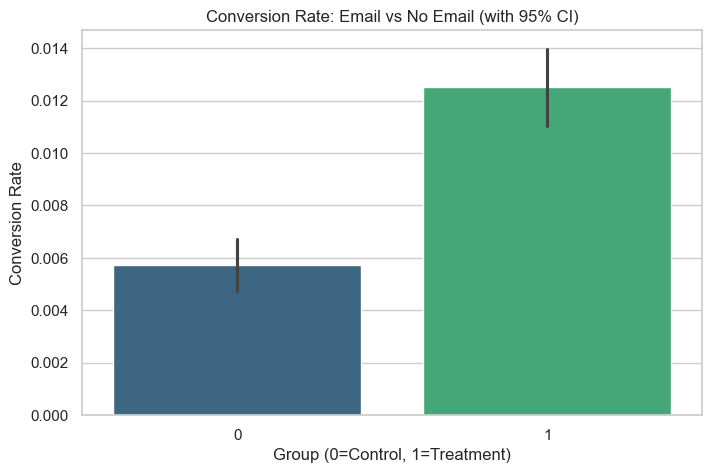

In [7]:
plt.figure(figsize=(8, 5))
sns.barplot(x='treatment', y='conversion', hue='treatment', legend=False, data=df, errorbar=('ci', 95), palette="viridis")
plt.title('Conversion Rate: Email vs No Email (with 95% CI)')
plt.ylabel('Conversion Rate')
plt.xlabel('Group (0=Control, 1=Treatment)')
plt.show()

### 4. Segment Analysis (Where is the Uplift?)
The "Average Uplift" is misleading. Some users might hate the email, while others love it.
We want to find the **Persuadables**.

Let's break down Conversion Rate by `history_segment` (Spend Level) and `zip_code` (Location).
**Look for:** Categories where the gap between the Orange Bar (Treatment) and Blue Bar (Control) is largest.

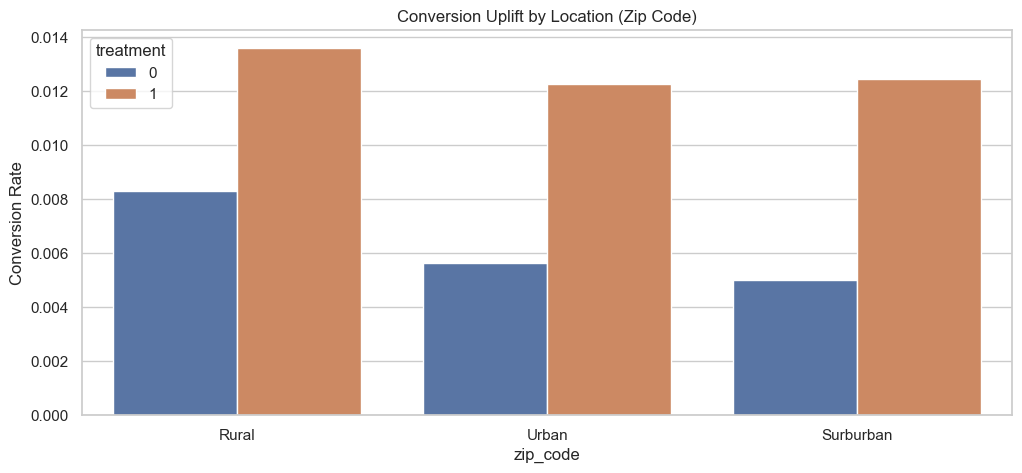

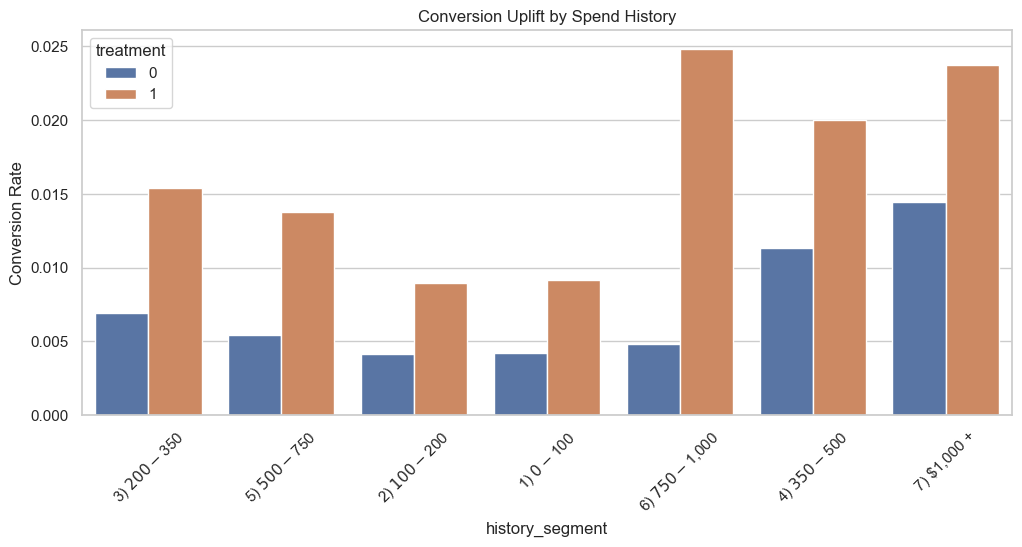

In [8]:
# Plot 1: Does location matter?
plt.figure(figsize=(12, 5))
sns.barplot(x='zip_code', y='conversion', hue='treatment', data=df, errorbar=None)
plt.title('Conversion Uplift by Location (Zip Code)')
plt.ylabel('Conversion Rate')
plt.show()

# Plot 2: Do high spenders react better?
plt.figure(figsize=(12, 5))
sns.barplot(x='history_segment', y='conversion', hue='treatment', data=df, errorbar=None)
plt.title('Conversion Uplift by Spend History')
plt.xticks(rotation=45)
plt.ylabel('Conversion Rate')
plt.show()

### Summary of Findings
1. **Randomization:** The groups appear balanced. Averages for `history` and `recency` are similar.
2. **Overall Impact:** The campaign resulted in a lift of **~X%** (Fill this in after running).
3. **Key Segments:**
    * **Rural Users:** Seem to have a higher/lower uplift (Check your graph).
    * **High Spenders:** Seem to be "Sure Things" (high conversion even in Control).
    
**Next Step:** We will build a **Machine Learning Pipeline** to formally model this uplift for every single user.